# 七、决策树

### 1. 基本原理

- 相似的输入导致相似的输出。

- 例如：
    - 年龄：青年-1，中年-2，老年-3
    - 学历：专科-1，本科-2，硕士-3，博士-4
    - 经验：缺乏-1，一般-2，丰富-3，资深-4
    - 性别：男-1，女-2
    - 薪资：1-低，2-中，3-高，4-超高

年龄|学历|工作经验|性别|薪资数|薪资类
:-:|:-:|:-:|:-:|:-:|:-:|
1 | 1 | 1 | 2 | 5000 | 1
1 | 2 | 2 | 1 | 8000 | 2
2 | 3 | 3 | 2 | 10000 | 3
3 | 4 | 4 | 1 | 30000 | 4
1 | 2 | 2 | 1 | ? | ?

- 随着子表的划分，信息熵越来越小，信息量越来越大，数据越来越有序。

- 依次选择原始样本矩阵中的每一列，构建相应特征值相同的若干子表树，在叶级子表中所有特征值都是相同的，对于未知输出的输入，按照同样的规则，归属到某个叶级子表，将该子表中各样本的输出按照取平均(回归)或者取投票(分类)的方法，计算预测输出。

### 2. 工程优化

1. 根据信息熵的减少量计算每个特征对预测结果的影响程度，信息熵减少量越大的特征对预测结果的影响也越大。

2. 根据上一步计算出的影响程度，按照从大到小的顺序，选择划分子表的特征依据，即优先选择影响程度最大的特征。

3. 根据事先给定的条件，提前结束子表的划分过程，借以简化决策树的结构，缩短构建和搜索的时间，在预测精度牺牲不大的前提下，提高模型性能。

### 3. 集成算法(Ensemble learning)

1. 所谓集成算法，亦称集合弱学习方法，其核心思想就是，通过平均或者投票，将多个不同学习方法的结论加以综合，给出一个相对可靠预测结果。所选择的弱学习方法，在算法或数据上应该具备足够分散性，以体现相对不同的倾向性，这样得出的综合结论才能够更加泛化。

2. 基于决策树的集合算法，就是按照某种规则，构建多棵彼此不同的决策树模型，分别给出针对未知样本的预测结果，最后通过平均或投票得到相对综合的结论。

3. 根据构建多棵决策树所依据的规则不同，基于决策树的集成算法可被分为以下几种：
    1. Bagging(自举汇聚法)
        - BaggingClassifier/BaggingRegressor：从原始训练样本中，以有放回或无放回抽样的方式，随机选取部分样本，构建一棵决策树，重复以上过程，得到若干棵决策输，以此弱化某些强势样本对预测结果的影响力，提高模型精度。
        - RandomForest(随机森林)：如果在自助聚合的基础上，每次构建决策树时，不但随机选择样本(行)，而且其特征(列)也是随机选择的，则称为随机森林。
    3. Boosting(提升法)：
        - AdaBoost自适应提升算法（正向激励），它对分类错误属性的给予更大权重，再做下次迭代，直到收敛。AdaBoost是一个相对简单的Boosting算法，可以自己写代码实现，常见的做法是基模型用单层分类器实现（树桩），桩对应当前最适合划分的属性值位置。首先为训练样本分配相等的权重，构建第一棵决策树，用该决策树对训练样本进行预测，为预测错误的样本提升权重，再次构建下一棵决策树，以此类推，得到针对每个样本拥有不同权重的多棵决策树。

In [11]:
import sklearn.datasets as sd
import sklearn.utils as su
import sklearn.tree as st
import sklearn.ensemble as se
import sklearn.metrics as sm

# 加载数据
boston = sd.load_boston()
# 用随机方法打乱生成随机序列，然后赋值
x, y = su.shuffle(boston.data, boston.target, random_state=7)  # 输入矩阵、输出标签；为回归问题
# 生成训练集大小
train_size = int(len(x) * 0.8)
# 根据train_size来进行分区
train_x, test_x, train_y, test_y = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

# 决策树回归器
model = st.DecisionTreeRegressor(max_depth=4)
# 根据训练集建立模型
model.fit(train_x, train_y)

# 应用到测试集中，生成预测值y
pred_test_y = model.predict(test_x)
# 比较真实值和测试值得出的份
print(sm.r2_score(test_y, pred_test_y))

# 基于决策树的正向激励回归器，（原模型、评估器、权重初始化随机种子）
model = se.AdaBoostRegressor(st.DecisionTreeRegressor(max_depth=4), n_estimators=400, random_state=7)
# 重新建模
model.fit(train_x, train_y)
pred_test_y = model.predict(test_x)
print(sm.r2_score(test_y, pred_test_y))

0.8202560889408635
0.9068598725149652


### 5. 特征重要性

- 决策树模型，在确定划分子表优先选择特征的过程中，需要根据最大熵减原则，确定划分子表的依据，因此，作为学习模型的副产品，可以得到每个特征对于输出的影响力度，即特征重要性：feature_importances_，该输出与模型算法有关。代码：fi.py

- 学习模型关于特征重要性的计算，除了与选择的算法有关以外，还与数据的采集粒度有关。代码：bike.py

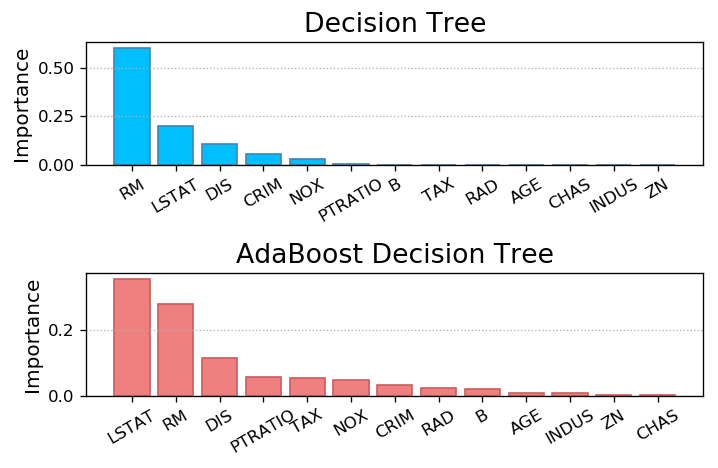

In [4]:
import numpy as np
import sklearn.datasets as sd
import sklearn.utils as su
import sklearn.tree as st
import sklearn.ensemble as se
import matplotlib.pyplot as mp

boston = sd.load_boston()
feature_names = boston.feature_names
x, y = su.shuffle(boston.data, boston.target, random_state=7)
train_size = int(len(x) * 0.8)
train_x, test_x, train_y, test_y = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

# 决策树回归器给出的特征重要性
model = st.DecisionTreeRegressor(max_depth=4)
model.fit(train_x, train_y)
fi_dt = model.feature_importances_

# 基于决策树的正向激励回归器给出的特征重要性
model = se.AdaBoostRegressor(st.DecisionTreeRegressor(max_depth=4), n_estimators=400, random_state=7)
model.fit(train_x, train_y)
fi_ab = model.feature_importances_

# 画图
mp.figure('Feature Importance', dpi=120)

mp.subplot(211)
mp.title('Decision Tree', fontsize=16)
mp.ylabel('Importance', fontsize=12)
mp.tick_params(labelsize=10)
mp.grid(axis='y', linestyle=':')
sorted_indices = fi_dt.argsort()[::-1]
pos = np.arange(sorted_indices.size)
mp.bar(pos, fi_dt[sorted_indices], facecolor='deepskyblue', edgecolor='steelblue')
mp.xticks(pos, feature_names[sorted_indices], rotation=30)

mp.subplot(212)
mp.title('AdaBoost Decision Tree', fontsize=16)
mp.ylabel('Importance', fontsize=12)
mp.tick_params(labelsize=10)
mp.grid(axis='y', linestyle=':')
sorted_indices = fi_ab.argsort()[::-1]
pos = np.arange(sorted_indices.size)
mp.bar(pos, fi_ab[sorted_indices], facecolor='lightcoral', edgecolor='indianred')
mp.xticks(pos, feature_names[sorted_indices], rotation=30)

mp.tight_layout()
mp.show()

0.8931889143860698
0.9187114066837555


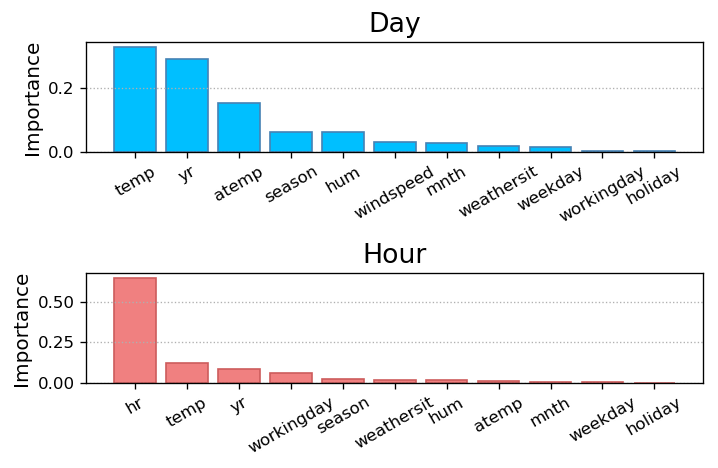

In [12]:
import csv
import numpy as np
import sklearn.utils as su
import sklearn.ensemble as se
import sklearn.metrics as sm
import matplotlib.pyplot as mp

# -----------------------------day数据------------------------
with open('../data/bike_day.csv', 'r') as f:
    reader = csv.reader(f)
    x, y = [], []
    for row in reader:
        x.append(row[2:13])
        y.append(row[-1])
fn_dy = np.array(x[0])
x = np.array(x[1:], dtype=float)
y = np.array(y[1:], dtype=float)
x, y = su.shuffle(x, y, random_state=7)
train_size = int(len(x) * 0.9)
train_x, test_x, train_y, test_y = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

# 随机森林回归器
model = se.RandomForestRegressor(max_depth=10, n_estimators=1000, min_samples_split=2)
model.fit(train_x, train_y)

# 基于“天”数据集的特征重要性
fi_dy = model.feature_importances_
pred_test_y = model.predict(test_x)
print(sm.r2_score(test_y, pred_test_y))

# -----------------------------hour数据------------------------
with open('../data/bike_hour.csv', 'r') as f:
    reader = csv.reader(f)
    x, y = [], []
    for row in reader:
        x.append(row[2:13])
        y.append(row[-1])
fn_hr = np.array(x[0])
x = np.array(x[1:], dtype=float)
y = np.array(y[1:], dtype=float)
x, y = su.shuffle(x, y, random_state=7)
train_size = int(len(x) * 0.9)
train_x, test_x, train_y, test_y = \
    x[:train_size], x[train_size:], \
    y[:train_size], y[train_size:]

# 随机森林回归器
model = se.RandomForestRegressor(max_depth=10, n_estimators=1000, min_samples_split=2)
model.fit(train_x, train_y)

# 基于“小时”数据集的特征重要性
fi_hr = model.feature_importances_
pred_test_y = model.predict(test_x)
print(sm.r2_score(test_y, pred_test_y))

# -----------------------------------------
mp.figure('Bike', dpi=120)
mp.subplot(211)
mp.title('Day', fontsize=16)
mp.ylabel('Importance', fontsize=12)
mp.tick_params(labelsize=10)
mp.grid(axis='y', linestyle=':')
sorted_indices = fi_dy.argsort()[::-1]
pos = np.arange(sorted_indices.size)
mp.bar(pos, fi_dy[sorted_indices], facecolor='deepskyblue', edgecolor='steelblue')
mp.xticks(pos, fn_dy[sorted_indices], rotation=30)

mp.subplot(212)
mp.title('Hour', fontsize=16)
mp.ylabel('Importance', fontsize=12)
mp.tick_params(labelsize=10)
mp.grid(axis='y', linestyle=':')
sorted_indices = fi_hr.argsort()[::-1]
pos = np.arange(sorted_indices.size)
mp.bar(pos, fi_hr[sorted_indices], facecolor='lightcoral', edgecolor='indianred')
mp.xticks(pos, fn_hr[sorted_indices], rotation=30)

mp.tight_layout()
mp.show()